In [1]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
from cycler import cycler

#### Auxiliary functions used to generate plots

In [2]:
def plot_comparison_metric(competitors: dict[str, pd.DataFrame],
                           column : str,
                           title_plot : str,
                           y_label : str) :
    ''' 
    This function generates a plot that compares various scoring plugin under some metric as the % of requested
    GPU cluster resources increases.
    '''
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    for k, v in competitors.items() : 
        ax1.plot(v.index, v[column], label=k)
    ax1.set_xlabel('% GPU cluster capacity requested by arrived pods')
    ax1.set_ylabel(y_label)
    
    # Legends
    ax1.legend()
    
    plt.title(title_plot)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
def plot_failed_relative(competitors_sched: dict[str, pd.DataFrame], 
                         reference_competitor : str, column_sched : str, title_plot : str) :
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    reference = competitors_sched[reference_competitor]
    for k, v in competitors_sched.items() :
        if k == reference_competitor: continue
        ax1.plot(v.index, v[column_sched] - reference[column_sched], label=k)
    ax1.set_xlabel('% GPU cluster capacity requested by arrived pods')
    ax1.set_ylabel(f'Difference w.r.t. {reference_competitor}')
    
    # Legends
    ax1.legend()
    
    plt.title(title_plot)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_energy_savings(competitors_pwr: dict[str, pd.DataFrame], 
                        reference_competitor : str, column_power : str, title_plot : str) :
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    reference = competitors_pwr[reference_competitor]
    for k, v in competitors_pwr.items() :
        if k == reference_competitor: continue
        ax1.plot(v.index, (reference[column_power] - v[column_power]) / reference[column_power] * 100, label=k)
    ax1.set_xlabel('% GPU cluster capacity requested by arrived pods')
    ax1.set_ylabel(f'Percentage power savings w.r.t. {reference_competitor}')
    
    # Legends
    ax1.legend()
    
    plt.title(title_plot)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
def plot_efficiency(competitors_pwr: dict[str, pd.DataFrame],
                    competitors_sched: dict[str, pd.DataFrame],
                    column_power_gpu : str, column_used_gpu_milli : str,
                    title_plot : str) :
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Apply the line styles cycle to the axes
    line_styles = ['-', '--', ':', '-.'] * 2
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange'] 
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']
    ax1.set_prop_cycle(cycler('linestyle', line_styles) + cycler('color', colors))
    
    for k in competitors_pwr.keys() :
        ax1.plot(competitors_pwr[k].index, competitors_sched[k][column_used_gpu_milli] / competitors_pwr[k][column_power_gpu], label=k)
    ax1.set_xlabel('% GPU cluster capacity requested by arrived pods')
    ax1.set_ylabel('Ratio GPU resources used (in millis) per watt')
    
    # Legends
    ax1.legend()
    
    plt.title(title_plot)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Retrieve power consumption and failed pods data from the experiments

In [6]:
# Dictionaries where the results will be stored.
df_pwr_dict = {}
df_frag_dict = {}
df_sched_pod_dict = {}

DATADIR = "./2024_0606"
data = Path(DATADIR)

fileDirs = sorted([x for x in data.iterdir() if x.is_dir()])
for fdir in fileDirs:
    df_pwr_dict[fdir.name] = {}
    df_frag_dict[fdir.name] = {}
    df_sched_pod_dict[fdir.name] = {}

    policyDirs = sorted([x for x in fdir.iterdir() if x.is_dir()])
    for pdir in policyDirs:
        print(f"Processing data for set of experiments: {fdir.name}.{pdir.name}")
        
        tuneDirs = sorted([x for x in pdir.iterdir() if x.is_dir()])
        for tdir in tuneDirs:
            seedDirs = sorted([x for x in tdir.iterdir() if x.is_dir()])
            for sdir in seedDirs:
                pwrfile = sdir / 'analysis_pwr.csv'
                grep = sdir / 'analysis_grep.out'
                alloc = sdir / 'analysis_allo.csv'
                schedfile = sdir / 'analysis_cdol.csv'
                fragfile = sdir / 'analysis_frag.csv'

                # Retrieve the total GPU cluster capacity (in millis).
                try:
                    with open(grep, 'r') as file:
                        content = file.read()  # Read the entire file into a string
                        # Find the position of 'allocation: ' in the content
                        start_idx = content.find('MilliGpu: ')
                        if start_idx != -1:
                            # Find the end of the line
                            end_idx = content.find('\n', start_idx)
                            # Extract the allocation part
                            selection = content[start_idx:end_idx]
                            # Extract the integer part by splitting the string
                            allocation_value = int(selection.split("/")[1].split(")")[0])
                        else:
                            raise Exception("MilliGpu cluster info not found. Error!\n")

                except Exception as e:
                    print("ERROR grep analysis: %s\n" % (e))

                # print(f"Total GPU cluster capacity: {allocation_value}\n")

                
                
                ### Collect telemetry about the GPU workload (in millis) that the cluster has received. ###
                try:
                    df_allo = pd.read_csv(alloc)
                    df_allo.rename(columns = lambda x: x.split('-')[-1], inplace=True)
                    cum_gpu_allo = df_allo.loc[:, 'arrived_gpu_milli'] / allocation_value

                except Exception as e:
                    print("ERROR alloc analysis: %s\n" % (e))

                # print(df_allo)
                # sys.exit() # DEBUG!
                

                
                # Set up the index for GPU requests received by the cluster.
                new_index = np.arange(0, 1.205, 0.005)

                ### Collect telemetry about power consumption. ###
                try:
                    df_pwr = pd.read_csv(pwrfile)
                    df_pwr.rename(columns = lambda x: x.split('-')[-1], inplace=True)
                    df_pwr["cumulative_workload"] = cum_gpu_allo
                    df_pwr.set_index("cumulative_workload", inplace = True)

                    # Remove rows with duplicated index entries, keeping only the first entry for each group of duplicates.
                    # Then, add the entries in new_index in df_pwr's existing index via a union.
                    # Then, reindex and interpolate the missing values.
                    # Finally, keep only the rows whose index entries are present in new_index (i.e., the regularly spaced ones).
                    df_pwr = df_pwr[~df_pwr.index.duplicated(keep='first')]
                    df_pwr = df_pwr.reindex(df_pwr.index.union(new_index)).interpolate(method='linear').ffill().bfill()
                    df_pwr = df_pwr.loc[new_index]
                    if df_pwr.isna().any().any(): 
                        # print(df_pwr[df_pwr.isna().any(axis=1)])
                        raise Exception("dataframe contains NaNs!\n")
                        
                    df_pwr_dict[fdir.name].setdefault(pdir.name, list()).append(df_pwr)

                except Exception as e:
                    print("ERROR power analysis: %s\n" % (e))

                # print(df_pwr)
                # sys.exit() # DEBUG!



                ### Collect telemetry about power consumption. ###
                try:
                    df_frag = pd.read_csv(fragfile)
                    df_frag.rename(columns = lambda x: x.split('-')[-1], inplace=True)
                    df_frag = df_frag[["origin_ratio"]]
                    df_frag["cumulative_workload"] = cum_gpu_allo
                    df_frag.set_index("cumulative_workload", inplace = True)

                    # Remove rows with duplicated index entries, keeping only the first entry for each group of duplicates.
                    # Then, add the entries in new_index in df_pwr's existing index via a union.
                    # Then, reindex and interpolate the missing values.
                    # Finally, keep only the rows whose index entries are present in new_index (i.e., the regularly spaced ones).
                    df_frag = df_frag[~df_frag.index.duplicated(keep='first')]
                    df_frag = df_frag.reindex(df_frag.index.union(new_index)).interpolate(method='linear').ffill().bfill()
                    df_frag = df_frag.loc[new_index]
                    if df_frag.isna().any().any(): 
                        # print(df_frag[df_frag.isna().any(axis=1)])
                        raise Exception("dataframe contains NaNs!\n")
                        
                    df_frag_dict[fdir.name].setdefault(pdir.name, list()).append(df_frag)

                except Exception as e:
                    print("ERROR fragmentation analysis: %s\n" % (e))

                #print(df_frag)
                #sys.exit() # DEBUG!
                

                
                ### Collect telemetry about pods that the cluster failed to schedule. ###
                try:
                    df_sched_pod = pd.read_csv(schedfile)
                    df_sched_pod.rename(columns = lambda x: x.split('-')[-1], inplace=True)
                    df_sched_pod = df_sched_pod[['event']]
                    df_sched_pod["issued_pods"] = df_sched_pod.index + 1
                    df_sched_pod["cumulative_workload"] = cum_gpu_allo
                    df_sched_pod['event'] = 1 * (df_sched_pod['event'] == 'failed')
                    df_sched_pod['event'] = df_sched_pod['event'].cumsum()
                    df_sched_pod.rename(columns = {'event' : 'failed_pods_cumsum'}, inplace = True)
                    df_sched_pod['used_gpu_milli'] = df_allo['used_gpu_milli']
                    df_sched_pod['ratio_failed_pods'] = df_sched_pod["failed_pods_cumsum"] / df_sched_pod["issued_pods"]
                    df_sched_pod['successful_pods'] = df_sched_pod["issued_pods"] - df_sched_pod["failed_pods_cumsum"]
                    df_sched_pod.set_index("cumulative_workload", inplace = True)

                    df_sched_pod = df_sched_pod[~df_sched_pod.index.duplicated(keep='first')]
                    df_sched_pod = df_sched_pod.reindex(df_sched_pod.index.union(new_index)).interpolate(method='linear').ffill().bfill()
                    df_sched_pod = df_sched_pod.loc[new_index]
                    if df_sched_pod.isna().any().any(): 
                        raise Exception("dataframe contains NaNs!\n")
                    
                    df_sched_pod_dict[fdir.name].setdefault(pdir.name, list()).append(df_sched_pod)
                
                except Exception as e:
                    print("ERROR scheduling analysis: %s\n" % (e))

                # print(df_sched_pod)
                # sys.exit() # DEBUG!


# display(df_pwr_dict.keys())
# display(df_pwr_dict)
# display(df_sched_pod_dict.keys())
# display(df_sched_pod_dict)

Processing data for set of experiments: openb_pod_list_default.01-Random
Processing data for set of experiments: openb_pod_list_default.02-DotProd
Processing data for set of experiments: openb_pod_list_default.03-GpuClustering
Processing data for set of experiments: openb_pod_list_default.04-GpuPacking
Processing data for set of experiments: openb_pod_list_default.05-BestFit
Processing data for set of experiments: openb_pod_list_default.06-FGD
Processing data for set of experiments: openb_pod_list_default.07-PWR
Processing data for set of experiments: openb_pod_list_default.08-PWR_500_FGD_500
Processing data for set of experiments: openb_pod_list_default.09-PWR_300_FGD_700
Processing data for set of experiments: openb_pod_list_default.10-PWR_200_FGD_800
Processing data for set of experiments: openb_pod_list_default.11-PWR_100_FGD_900
Processing data for set of experiments: openb_pod_list_default.12-PWR_50_FGD_950
Processing data for set of experiments: openb_pod_list_default.13-PWR_25_

#### Compute the average power consumption and number of failed plugins within each score plugin's set of runs.

In [7]:
# Set of competitors to exclude to avoid cluttering the plots too much.
set_remove_competitors = {#'01-Random',
                          '02-DotProd',
                          #'03-GpuClustering',
                          #'04-GpuPacking',
                          '05-BestFit',
                          '08-PWR_500_FGD_500', 
                          '13-PWR_25_FGD_975', 
                          '09-PWR_300_FGD_700', 
                          '10-PWR_200_FGD_800'}


# Compute the average power consumption for each score plugin.
dict_pwr_final_res = {}
for k in df_pwr_dict.keys() :
    dict_pwr_final_res[k] = {}
    for k2 in df_pwr_dict[k].keys() :
        if k2 in set_remove_competitors : continue
        print(f"Computing cluster power consumption mean for level ({k},{k2}) ({len(df_pwr_dict[k][k2])} repetitions found)")
        dict_pwr_final_res[k][k2] = sum(df_pwr_dict[k][k2]) / len(df_pwr_dict[k][k2])


# Compute the average power consumption for each score plugin.
dict_frag_final_res = {}
for k in df_frag_dict.keys() :
    dict_frag_final_res[k] = {}
    for k2 in df_frag_dict[k].keys() :
        if k2 in set_remove_competitors : continue
        print(f"Computing fragmentation mean for level ({k},{k2}) ({len(df_frag_dict[k][k2])} repetitions found)")
        dict_frag_final_res[k][k2] = sum(df_frag_dict[k][k2]) / len(df_frag_dict[k][k2])


# Compute the average failed pod for each score plugin.
dict_sched_final_res = {}
for k in df_sched_pod_dict.keys() :
    dict_sched_final_res[k] = {}
    for k2 in df_sched_pod_dict[k].keys() :
        if k2 in set_remove_competitors : continue
        print(f"Computing mean # of pods that have failed to schedule for level ({k},{k2}) ({len(df_sched_pod_dict[k][k2])} repetitions found)")
        dict_sched_final_res[k][k2] = sum(df_sched_pod_dict[k][k2]) / len(df_sched_pod_dict[k][k2])

    
# display(dict_pwr_final_res.keys())
# display(dict_pwr_final_res)
# display(dict_sched_final_res.keys())
# display(dict_sched_final_res)

Computing cluster power consumption mean for level (openb_pod_list_default,01-Random) (10 repetitions found)
Computing cluster power consumption mean for level (openb_pod_list_default,03-GpuClustering) (10 repetitions found)
Computing cluster power consumption mean for level (openb_pod_list_default,04-GpuPacking) (10 repetitions found)
Computing cluster power consumption mean for level (openb_pod_list_default,06-FGD) (10 repetitions found)
Computing cluster power consumption mean for level (openb_pod_list_default,07-PWR) (10 repetitions found)
Computing cluster power consumption mean for level (openb_pod_list_default,11-PWR_100_FGD_900) (10 repetitions found)
Computing cluster power consumption mean for level (openb_pod_list_default,12-PWR_50_FGD_950) (10 repetitions found)
Computing cluster power consumption mean for level (openb_pod_list_gpuspec33,01-Random) (10 repetitions found)
Computing cluster power consumption mean for level (openb_pod_list_gpuspec33,03-GpuClustering) (10 repet

### Generation of power consumption plots: overall, GPU only, and CPU only 

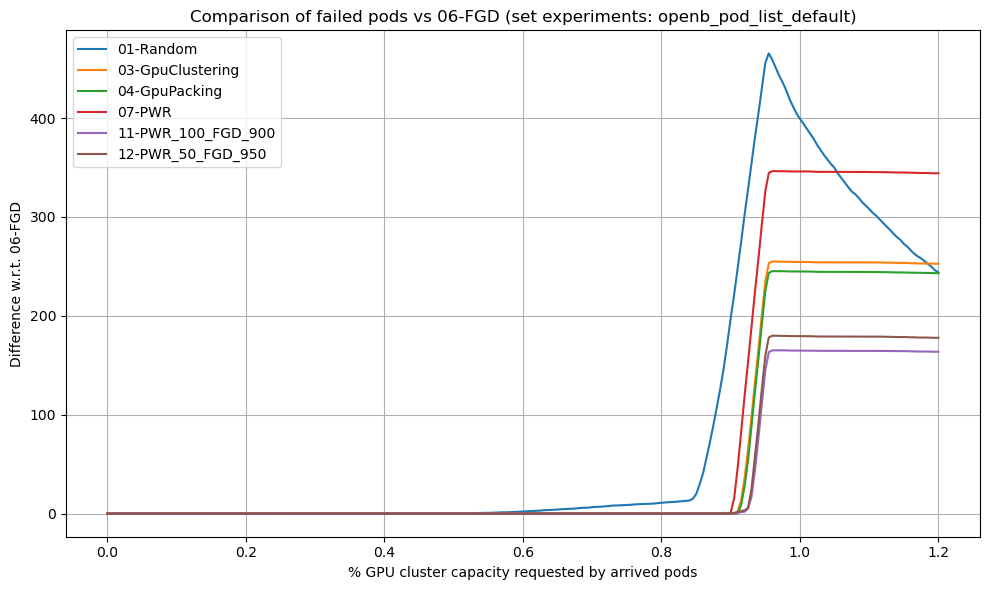

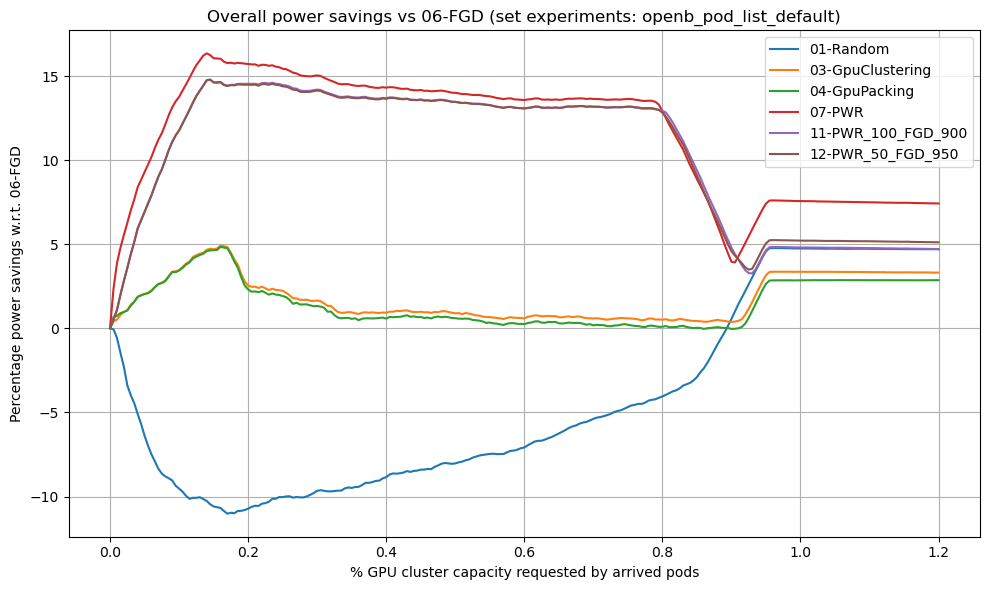

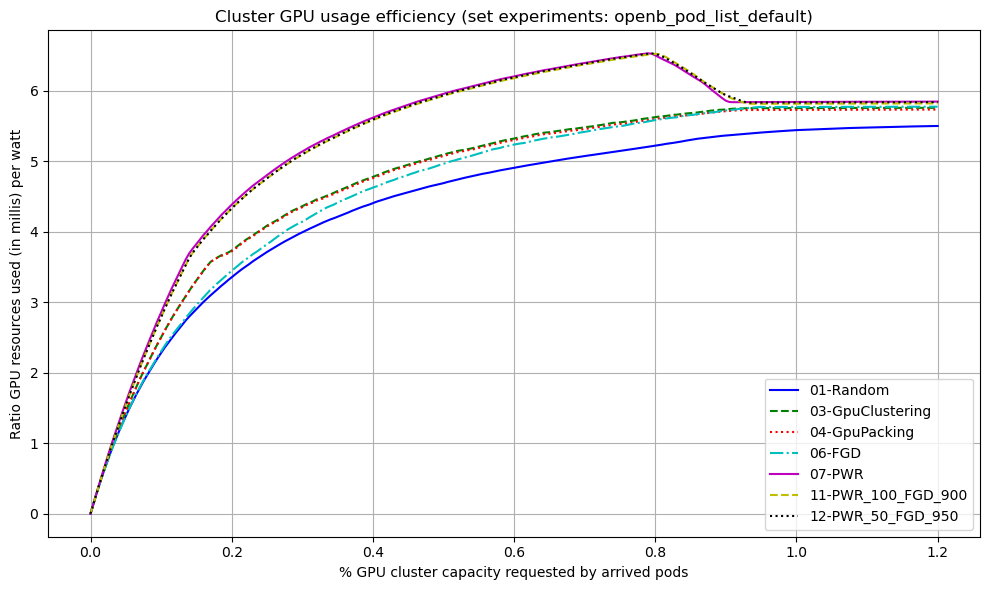

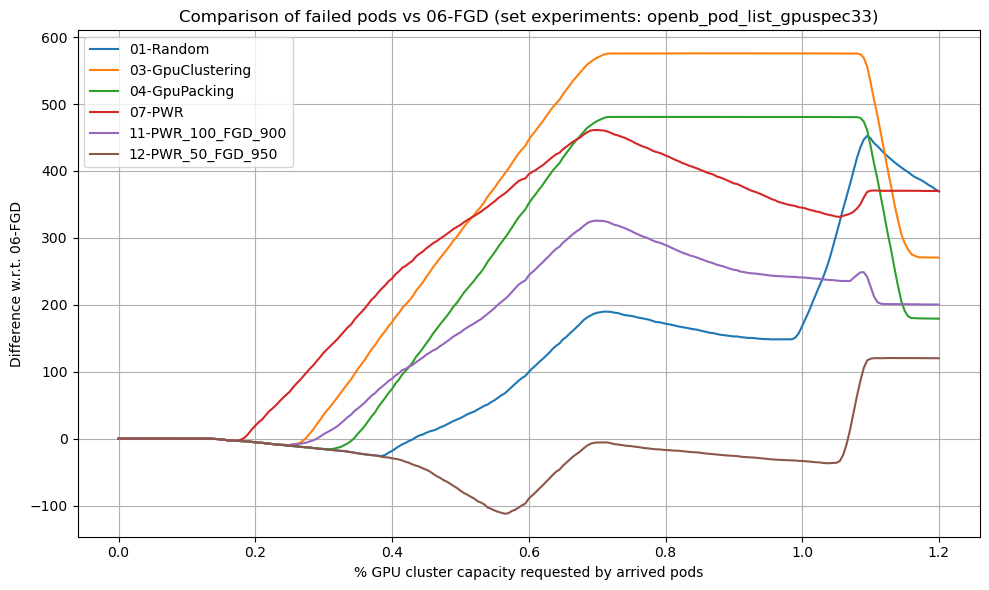

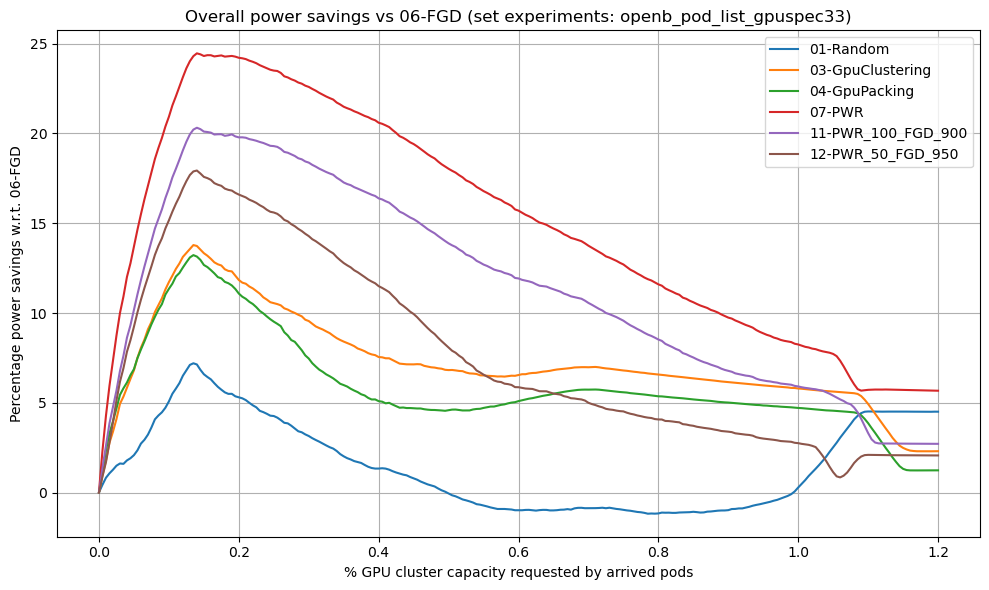

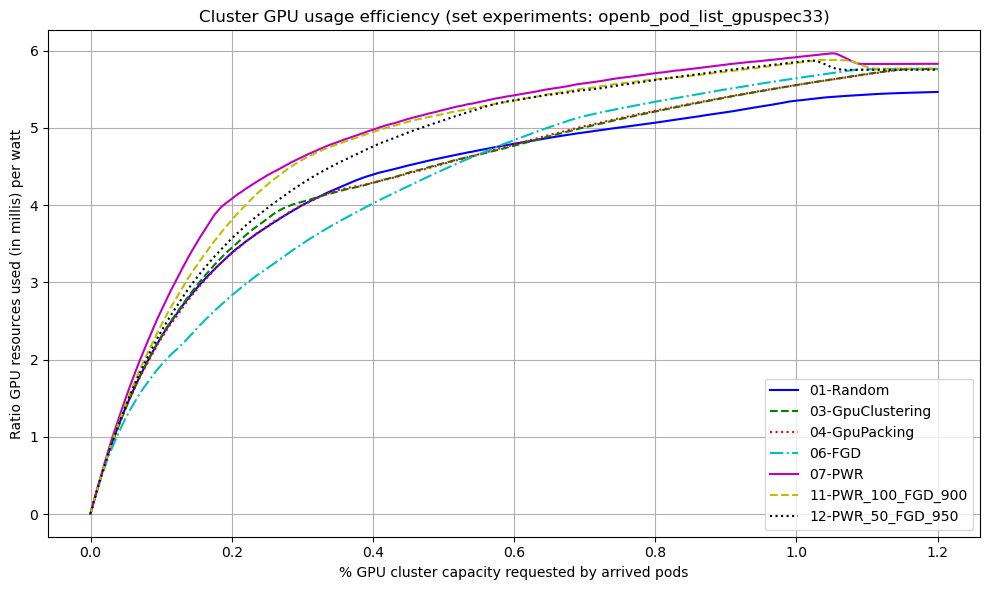

In [14]:
reference_competitor = '06-FGD'
for level in dict_pwr_final_res.keys() :
    
    # Plot the difference between number of pods that failed with some competitor w.r.t. the reference competitor.
    # X-axis represents the arrived workloads in % of GPU resources available in the cluster. 
    plot_failed_relative(dict_sched_final_res[level], reference_competitor, 
                         "failed_pods_cumsum", f"Comparison of failed pods vs {reference_competitor} (set experiments: {level})")

    # Plot the energy savings achieved with some competitor w.r.t. the reference competitor.
    # X-axis represents the arrived workloads in % of GPU resources available in the cluster. 
    plot_energy_savings(dict_pwr_final_res[level], reference_competitor, 
                        "power_cluster", f"Overall power savings vs {reference_competitor} (set experiments: {level})")

    plot_efficiency(dict_pwr_final_res[level],
                    dict_sched_final_res[level],
                    "power_cluster_GPU", "used_gpu_milli",
                    f"Cluster GPU usage efficiency (set experiments: {level})")

    # Plot the overall cluster energy consumption w.r.t. the arrived workloads in % of GPU resources available in the cluster.
    if False :
        plot_comparison_metric(dict_pwr_final_res[level],
                               "power_cluster",
                               f"Overall cluster energy consumption (set experiments: {level})",
                               "Watts")


    # Plot the cluster fragmentation ratio w.r.t. the arrived workloads in % of GPU resources available in the cluster. 
    if False :
        plot_comparison_metric(dict_frag_final_res[level], 
                               "origin_ratio",
                               f"Cluster fragmentation ratio (set experiments: {level})",
                               "Cluster fragmentation ratio")


    # Plot the GPU cluster energy consumption w.r.t. the arrived workloads in % of GPU resources available in the cluster.
    if False :
        plot_comparison_metric(dict_pwr_final_res[level],
                               "power_cluster_GPU",
                               f'GPU cluster energy consumption (set experiments: {level})',
                               "Watts")
        plot_energy_savings(dict_pwr_final_res[level], reference_competitor, 
                            "power_cluster_GPU", f"GPU power savings vs {reference_competitor} (set experiments: {level})")

    

    # Plot the CPU cluster energy consumption w.r.t. the arrived workloads in % of GPU resources available in the cluster.
    if False :
        plot_comparison_metric(dict_pwr_final_res[level],
                               "power_cluster_CPU",
                               f'CPU cluster energy consumption (set experiments: {level})',
                               "Watts")
        plot_energy_savings(dict_pwr_final_res[level], reference_competitor, 
                            "power_cluster_CPU", f"CPU cluster power savings vs {reference_competitor} (set experiments: {level})")